In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tabulate import tabulate
from scipy.stats import skew, kurtosis, norm
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import brentq
from tqdm import tqdm

# Step 1

True theta (numerical): 1.4626517459071815

Estimator A (Antithetic):
Mean: 1.462186, Std: 0.166694, 95% CI: (1.461153204607999, 1.4632195615090797)

Estimator B (Plain MC):
Mean: 1.464261, Std: 0.336117, 95% CI: (1.4621781945117305, 1.4663447451750375)


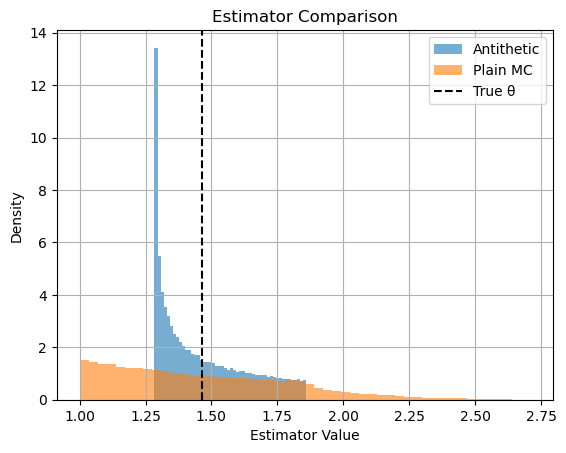

In [2]:
np.random.seed(42)

# Number of simulations
N = 10**5

# --- Estimator A (Antithetic) ---
U = np.random.uniform(0, 1, N)
theta_A_samples = 0.5 * (np.exp(U**2) + np.exp((1 - U)**2))

# --- Estimator B (Plain Monte Carlo) ---
U1 = np.random.uniform(0, 1, N)
U2 = np.random.uniform(0, 1, N)
theta_B_samples = 0.5 * (np.exp(U1**2) + np.exp(U2**2))

# --- True value using numerical integration for reference ---
true_theta, _ = quad(lambda x: np.exp(x**2), 0, 1)


def stats(estimator_samples):
    mean = np.mean(estimator_samples)
    std = np.std(estimator_samples, ddof=1)
    ci_low = mean - 1.96 * std / np.sqrt(N)
    ci_high = mean + 1.96 * std / np.sqrt(N)
    return mean, std, (ci_low, ci_high)

mean_A, std_A, ci_A = stats(theta_A_samples)
mean_B, std_B, ci_B = stats(theta_B_samples)

# --- Output ---
print("True theta (numerical):", true_theta)
print("\nEstimator A (Antithetic):")
print(f"Mean: {mean_A:.6f}, Std: {std_A:.6f}, 95% CI: {ci_A}")

print("\nEstimator B (Plain MC):")
print(f"Mean: {mean_B:.6f}, Std: {std_B:.6f}, 95% CI: {ci_B}")

plt.hist(theta_A_samples, bins=50, alpha=0.6, label="Antithetic", density=True)
plt.hist(theta_B_samples, bins=50, alpha=0.6, label="Plain MC", density=True)
plt.axvline(true_theta, color='black', linestyle='--', label='True θ')
plt.title("Estimator Comparison")
plt.legend()
plt.xlabel("Estimator Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()



# Step 2

In [3]:
# Set random seed
np.random.seed(42)

# Sample size
N = 10**5

# Generate U ~ U[0,1]
U = np.random.uniform(0, 1, N)
X = np.sqrt(1 - U**2)  

# Control variate 1: U
C1 = U
mean_C1 = 0.5

# Control variate 2: U^2
C2 = U**2
mean_C2 = 1/3

# Compute beta coefficients
def get_beta(X, C):
    cov = np.cov(X, C, ddof=1)[0, 1]
    var = np.var(C, ddof=1)
    return cov / var

beta1 = get_beta(X, C1)
beta2 = get_beta(X, C2)

# Control variate estimators
theta_cv1 = X - beta1 * (C1 - mean_C1)
theta_cv2 = X - beta2 * (C2 - mean_C2)

def stats(x):
    mean = np.mean(x)
    std = np.std(x, ddof=1)
    ci = (mean - 1.96 * std / np.sqrt(N), mean + 1.96 * std / np.sqrt(N))
    return mean, std, ci

mean_plain, std_plain, ci_plain = stats(X)
mean_cv1, std_cv1, ci_cv1 = stats(theta_cv1)
mean_cv2, std_cv2, ci_cv2 = stats(theta_cv2)

# True value
true_theta = np.pi / 4

print(f"True value (π/4): {true_theta:.6f}")
print("\n--- Without Control Variate ---")
print(f"Mean: {mean_plain:.6f}, Std: {std_plain:.6f}, 95% CI: {ci_plain}")

print("\n--- Control Variate: U ---")
print(f"Beta: {beta1:.6f}")
print(f"Mean: {mean_cv1:.6f}, Std: {std_cv1:.6f}, 95% CI: {ci_cv1}")

print("\n--- Control Variate: U^2 ---")
print(f"Beta: {beta2:.6f}")
print(f"Mean: {mean_cv2:.6f}, Std: {std_cv2:.6f}, 95% CI: {ci_cv2}")


True value (π/4): 0.785398

--- Without Control Variate ---
Mean: 0.786124, Std: 0.222217, 95% CI: (0.7847471174690774, 0.7875017480600861)

--- Control Variate: U ---
Beta: -0.710215
Mean: 0.785761, Std: 0.086277, 95% CI: (0.7852262307093397, 0.7862957294570466)

--- Control Variate: U^2 ---
Beta: -0.734942
Mean: 0.785606, Std: 0.040038, 95% CI: (0.7853582418167445, 0.785854557025233)


# Step 3

# 1.

# a)

Correlation and Control Coefficients (β):

(i)  ST                 → Corr: 0.8683,    β: 0.6530
(ii) Max(ST - K, 0)     → Corr: 0.8841,  β: 1.0592
(iii) Max(G_T - K, 0)   → Corr: 0.8446,   β: 2.3768
(iv) Max(S)             → Corr: 0.9933,  β: 0.9305


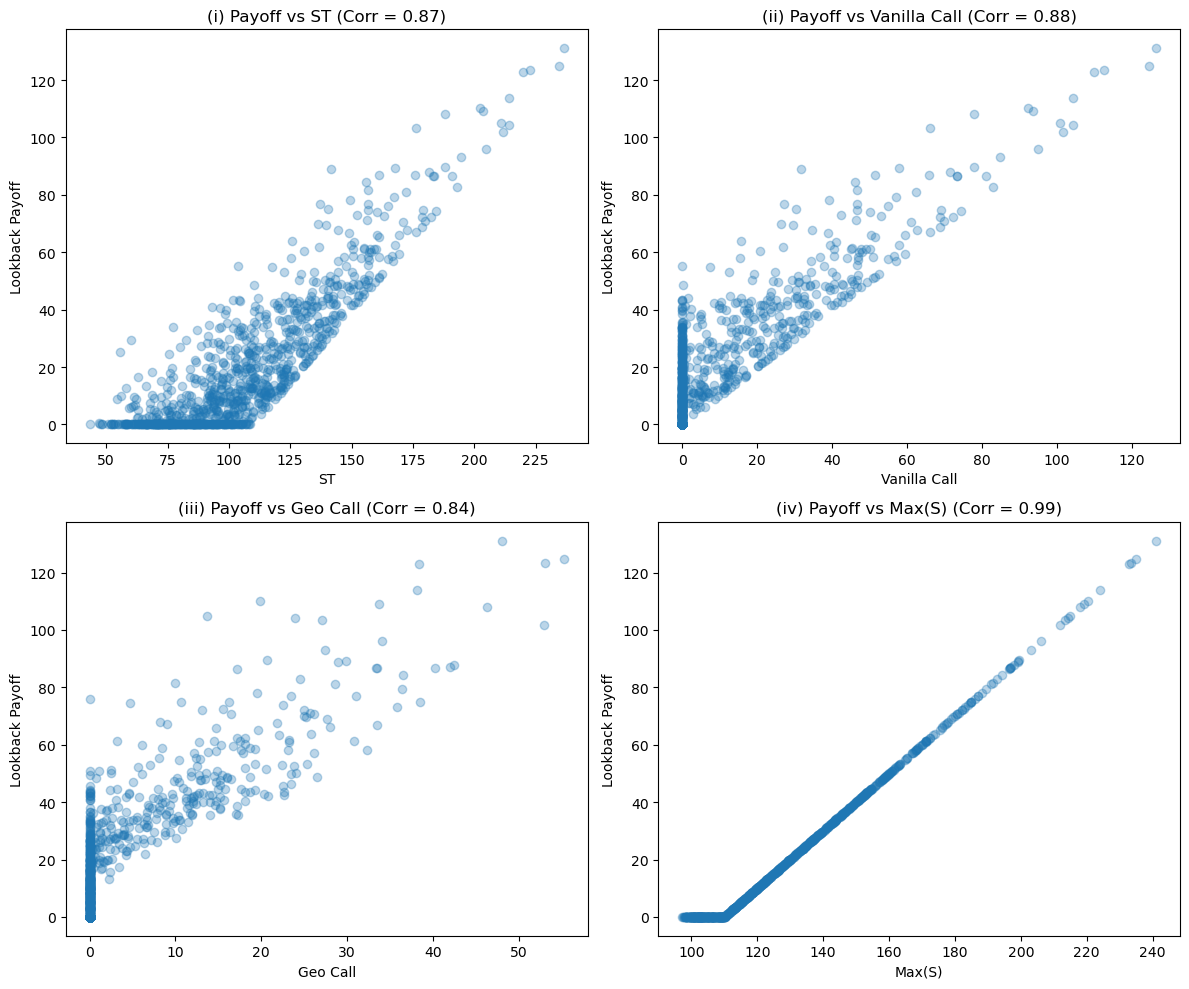

In [4]:
S0 = 100          
r = 0.05          
sigma = 0.3       
K = 110           
T = 1             
m = 365           
N0 = 1000         

dt = T / m

# --- Simulate GBM paths ---
np.random.seed(0)
Z = np.random.normal(size=(N0, m))
increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
log_paths = np.cumsum(increments, axis=1)
S_paths = S0 * np.exp(log_paths)

# --- Compute Quantities ---
ST = S_paths[:, -1]                                  
max_path = np.max(S_paths, axis=1)                   
geom_mean = np.exp(np.mean(np.log(S_paths), axis=1)) 
payoff = np.maximum(max_path - K, 0)                 
vanilla_call = np.maximum(ST - K, 0)                 
geo_call = np.maximum(geom_mean - K, 0)              

# --- Utility: Correlation and Beta ---
def correlation_and_beta(Y, C):
    corr = np.corrcoef(Y, C)[0, 1]
    cov = np.cov(Y, C, ddof=1)[0, 1]
    var = np.var(C, ddof=1)
    beta = cov / var
    return corr, beta

# --- Compute Correlations & Betas ---
corr_ST, beta_ST = correlation_and_beta(payoff, ST)
corr_call, beta_call = correlation_and_beta(payoff, vanilla_call)
corr_geo, beta_geo = correlation_and_beta(payoff, geo_call)
corr_maxS, beta_maxS = correlation_and_beta(payoff, max_path)

# --- Report Results ---
print("Correlation and Control Coefficients (β):\n")
print(f"(i)  ST                 → Corr: {corr_ST:.4f},    β: {beta_ST:.4f}")
print(f"(ii) Max(ST - K, 0)     → Corr: {corr_call:.4f},  β: {beta_call:.4f}")
print(f"(iii) Max(G_T - K, 0)   → Corr: {corr_geo:.4f},   β: {beta_geo:.4f}")
print(f"(iv) Max(S)             → Corr: {corr_maxS:.4f},  β: {beta_maxS:.4f}")

# --- Scatter Plots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(ST, payoff, alpha=0.3)
axs[0, 0].set_title(f"(i) Payoff vs ST (Corr = {corr_ST:.2f})")
axs[0, 0].set_xlabel("ST")
axs[0, 0].set_ylabel("Lookback Payoff")

axs[0, 1].scatter(vanilla_call, payoff, alpha=0.3)
axs[0, 1].set_title(f"(ii) Payoff vs Vanilla Call (Corr = {corr_call:.2f})")
axs[0, 1].set_xlabel("Vanilla Call")
axs[0, 1].set_ylabel("Lookback Payoff")

axs[1, 0].scatter(geo_call, payoff, alpha=0.3)
axs[1, 0].set_title(f"(iii) Payoff vs Geo Call (Corr = {corr_geo:.2f})")
axs[1, 0].set_xlabel("Geo Call")
axs[1, 0].set_ylabel("Lookback Payoff")

axs[1, 1].scatter(max_path, payoff, alpha=0.3)
axs[1, 1].set_title(f"(iv) Payoff vs Max(S) (Corr = {corr_maxS:.2f})")
axs[1, 1].set_xlabel("Max(S)")
axs[1, 1].set_ylabel("Lookback Payoff")

plt.tight_layout()
plt.show()


# b)

In [12]:
S0 = 100
r = 0.05
sigma = 0.3
K = 110
T = 1
m = 365
dt = T / m
discount = np.exp(-r * T)

np.random.seed(42)

# Names of control variates
cv_names = ['ST', 'Vanilla Call', 'Geo Call', 'Max S']

# Function to simulate and price with all control variates
def run_mc_with_control(N):
    Z = np.random.normal(size=(N, m))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S_paths = S0 * np.exp(log_paths)

    ST = S_paths[:, -1]
    max_S = np.max(S_paths, axis=1)
    geo_mean = np.exp(np.mean(np.log(S_paths), axis=1))

    # Main payoff
    lookback_payoff = np.maximum(max_S - K, 0)
    disc_payoff = discount * lookback_payoff

    # Control variates
    C1 = ST
    C2 = np.maximum(ST - K, 0)
    C3 = np.maximum(geo_mean - K, 0)
    C4 = max_S
    controls = [C1, C2, C3, C4]

    # Standard Monte Carlo
    mean_MC = np.mean(disc_payoff)
    std_MC = np.std(disc_payoff, ddof=1)
    ci_MC = (mean_MC - 1.96 * std_MC / np.sqrt(N), mean_MC + 1.96 * std_MC / np.sqrt(N))

    results = []

    # Add standard MC row
    results.append({
        'N': N,
        'Method': 'Standard MC',
        'Control': '-',
        'Price': mean_MC,
        'Std': std_MC,
        '95% CI Lower': ci_MC[0],
        '95% CI Upper': ci_MC[1],
        'Beta': '-'
    })

    # Monte Carlo with each control variate
    for i, C in enumerate(controls):
        cov = np.cov(disc_payoff, C, ddof=1)[0, 1]
        var = np.var(C, ddof=1)
        beta = cov / var
        C_mean = np.mean(C)
        cv_estimator = disc_payoff - beta * (C - C_mean)

        mean_CV = np.mean(cv_estimator)
        std_CV = np.std(cv_estimator, ddof=1)
        ci_CV = (mean_CV - 1.96 * std_CV / np.sqrt(N), mean_CV + 1.96 * std_CV / np.sqrt(N))

        results.append({
            'N': N,
            'Method': 'Control Variate',
            'Control': cv_names[i],
            'Price': mean_CV,
            'Std': std_CV,
            '95% CI Lower': ci_CV[0],
            '95% CI Upper': ci_CV[1],
            'Beta': round(beta, 4)
        })

    return results

# Run for all N
all_results = []
for N in [10**4, 10**5, 10**6]:
    all_results.extend(run_mc_with_control(N))

df = pd.DataFrame(all_results)
df_formatted = df.copy()
df_formatted[['Price', 'Std', '95% CI Lower', '95% CI Upper']] = df_formatted[
    ['Price', 'Std', '95% CI Lower', '95% CI Upper']
].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)

print(tabulate(df_formatted, headers='keys', tablefmt='grid'))


+----+---------+-----------------+--------------+---------+----------+----------------+----------------+--------+
|    |       N | Method          | Control      |   Price |      Std |   95% CI Lower |   95% CI Upper | Beta   |
+====+=========+=================+==============+=========+==========+================+================+========+
|  0 |   10000 | Standard MC     | -            | 18.6012 | 22.6969  |        18.1564 |        19.0461 | -      |
+----+---------+-----------------+--------------+---------+----------+----------------+----------------+--------+
|  1 |   10000 | Control Variate | ST           | 18.6012 | 11.3449  |        18.3789 |        18.8236 | 0.6218 |
+----+---------+-----------------+--------------+---------+----------+----------------+----------------+--------+
|  2 |   10000 | Control Variate | Vanilla Call | 18.6012 | 10.5306  |        18.3948 |        18.8076 | 1.0177 |
+----+---------+-----------------+--------------+---------+----------+----------------+-

C:\Users\19874\AppData\Local\Temp\ipykernel_26332\4200145728.py:90: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


# c)

In [6]:
# --- Control variates info ---
cv_names = ['ST', 'Vanilla Call', 'Geo Call', 'Max S']
betas = [beta_ST, beta_call, beta_geo, beta_maxS]

# --- Discount factor ---
discount = np.exp(-r * T)

# --- Monte Carlo estimation using fixed betas from part (a) ---
def run_fixed_beta_cv(N, betas):
    np.random.seed(42)
    Z = np.random.normal(size=(N, m))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S_paths = S0 * np.exp(log_paths)

    ST = S_paths[:, -1]
    max_S = np.max(S_paths, axis=1)
    geo_mean = np.exp(np.mean(np.log(S_paths), axis=1))

    payoff = np.maximum(max_S - K, 0)
    disc_payoff = discount * payoff

    controls = [
        ST,
        np.maximum(ST - K, 0),
        np.maximum(geo_mean - K, 0),
        max_S
    ]

    results = []

    # Standard Monte Carlo
    mean_mc = np.mean(disc_payoff)
    std_mc = np.std(disc_payoff, ddof=1)
    ci_mc = (
        mean_mc - 1.96 * std_mc / np.sqrt(N),
        mean_mc + 1.96 * std_mc / np.sqrt(N)
    )
    results.append({
        'N': N,
        'Method': 'Standard MC',
        'Control': '-',
        'Price': mean_mc,
        'Std': std_mc,
        '95% CI Lower': ci_mc[0],
        '95% CI Upper': ci_mc[1],
        'Beta': '-'
    })

    # Control variates
    for i, C in enumerate(controls):
        beta = betas[i]
        C_mean = np.mean(C)  # sample mean
        cv_estimator = disc_payoff - beta * (C - C_mean)
        mean_cv = np.mean(cv_estimator)
        std_cv = np.std(cv_estimator, ddof=1)
        ci_cv = (
            mean_cv - 1.96 * std_cv / np.sqrt(N),
            mean_cv + 1.96 * std_cv / np.sqrt(N)
        )

        results.append({
            'N': N,
            'Method': 'Control Variate',
            'Control': cv_names[i],
            'Price': mean_cv,
            'Std': std_cv,
            '95% CI Lower': ci_cv[0],
            '95% CI Upper': ci_cv[1],
            'Beta': round(beta, 4)
        })

    return results

# Run for all N values
all_results_c = []
for N in [10**4, 10**5, 10**6]:
    all_results_c.extend(run_fixed_beta_cv(N, betas))

df_c = pd.DataFrame(all_results_c)
df_c_formatted = df_c.copy()
cols = ['Price', 'Std', '95% CI Lower', '95% CI Upper']
df_c_formatted[cols] = df_c_formatted[cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)

print("\n📋 Part 1(c): Results Using Fixed Betas from Part 1(a)\n")
print(tabulate(df_c_formatted, headers="keys", tablefmt="grid"))



📋 Part 1(c): Results Using Fixed Betas from Part 1(a)

+----+---------+-----------------+--------------+---------+----------+----------------+----------------+--------+
|    |       N | Method          | Control      |   Price |      Std |   95% CI Lower |   95% CI Upper | Beta   |
+====+=========+=================+==============+=========+==========+================+================+========+
|  0 |   10000 | Standard MC     | -            | 18.6012 | 22.6969  |        18.1564 |        19.0461 | -      |
+----+---------+-----------------+--------------+---------+----------+----------------+----------------+--------+
|  1 |   10000 | Control Variate | ST           | 18.6012 | 11.3875  |        18.378  |        18.8244 | 0.653  |
+----+---------+-----------------+--------------+---------+----------+----------------+----------------+--------+
|  2 |   10000 | Control Variate | Vanilla Call | 18.6012 | 10.5624  |        18.3942 |        18.8083 | 1.0592 |
+----+---------+----------------

C:\Users\19874\AppData\Local\Temp\ipykernel_20840\3316235216.py:83: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_c_formatted[cols] = df_c_formatted[cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


# 2.

In [7]:
S0 = 100
r = 0.05
sigma = 0.3
K = 110
T = 1
m = 365
dt = T / m
discount = np.exp(-r * T)

# Function to simulate using antithetic variates
def lookback_antithetic_price(N):
    np.random.seed(42)
    Z = np.random.normal(size=(N, m))
    Z_antithetic = -Z  # antithetic pairs

    def simulate_paths(Z_block):
        increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_block
        log_paths = np.cumsum(increments, axis=1)
        return S0 * np.exp(log_paths)

    # Original and antithetic paths
    S_paths_1 = simulate_paths(Z)
    S_paths_2 = simulate_paths(Z_antithetic)

    max_1 = np.max(S_paths_1, axis=1)
    max_2 = np.max(S_paths_2, axis=1)

    payoff_1 = np.maximum(max_1 - K, 0)
    payoff_2 = np.maximum(max_2 - K, 0)

    avg_payoff = 0.5 * (payoff_1 + payoff_2)
    discounted = discount * avg_payoff

    mean = np.mean(discounted)
    std = np.std(discounted, ddof=1)
    ci = (mean - 1.96 * std / np.sqrt(N), mean + 1.96 * std / np.sqrt(N))

    return {
        'N': N,
        'Price': mean,
        'Std': std,
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1]
    }

# Run for all N
N_list = [10**4, 10**5, 10**6]
results = [lookback_antithetic_price(N) for N in N_list]

# Format results
df = pd.DataFrame(results)
df_formatted = df.copy()
cols = ['Price', 'Std', '95% CI Lower', '95% CI Upper']
df_formatted[cols] = df_formatted[cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)

print("\n📋 Lookback Call Pricing Using Antithetic Variates\n")
print(tabulate(df_formatted, headers='keys', tablefmt='grid'))



📋 Lookback Call Pricing Using Antithetic Variates

+----+---------+---------+---------+----------------+----------------+
|    |       N |   Price |     Std |   95% CI Lower |   95% CI Upper |
+====+=========+=========+=========+================+================+
|  0 |   10000 | 18.7985 | 11.4967 |        18.5732 |        19.0238 |
+----+---------+---------+---------+----------------+----------------+
|  1 |  100000 | 18.9177 | 11.4318 |        18.8469 |        18.9886 |
+----+---------+---------+---------+----------------+----------------+
|  2 | 1000000 | 18.9805 | 11.4507 |        18.9581 |        19.0029 |
+----+---------+---------+---------+----------------+----------------+


C:\Users\19874\AppData\Local\Temp\ipykernel_20840\945468238.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_formatted[cols] = df_formatted[cols].applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x)


# Step 4

# 1.

C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

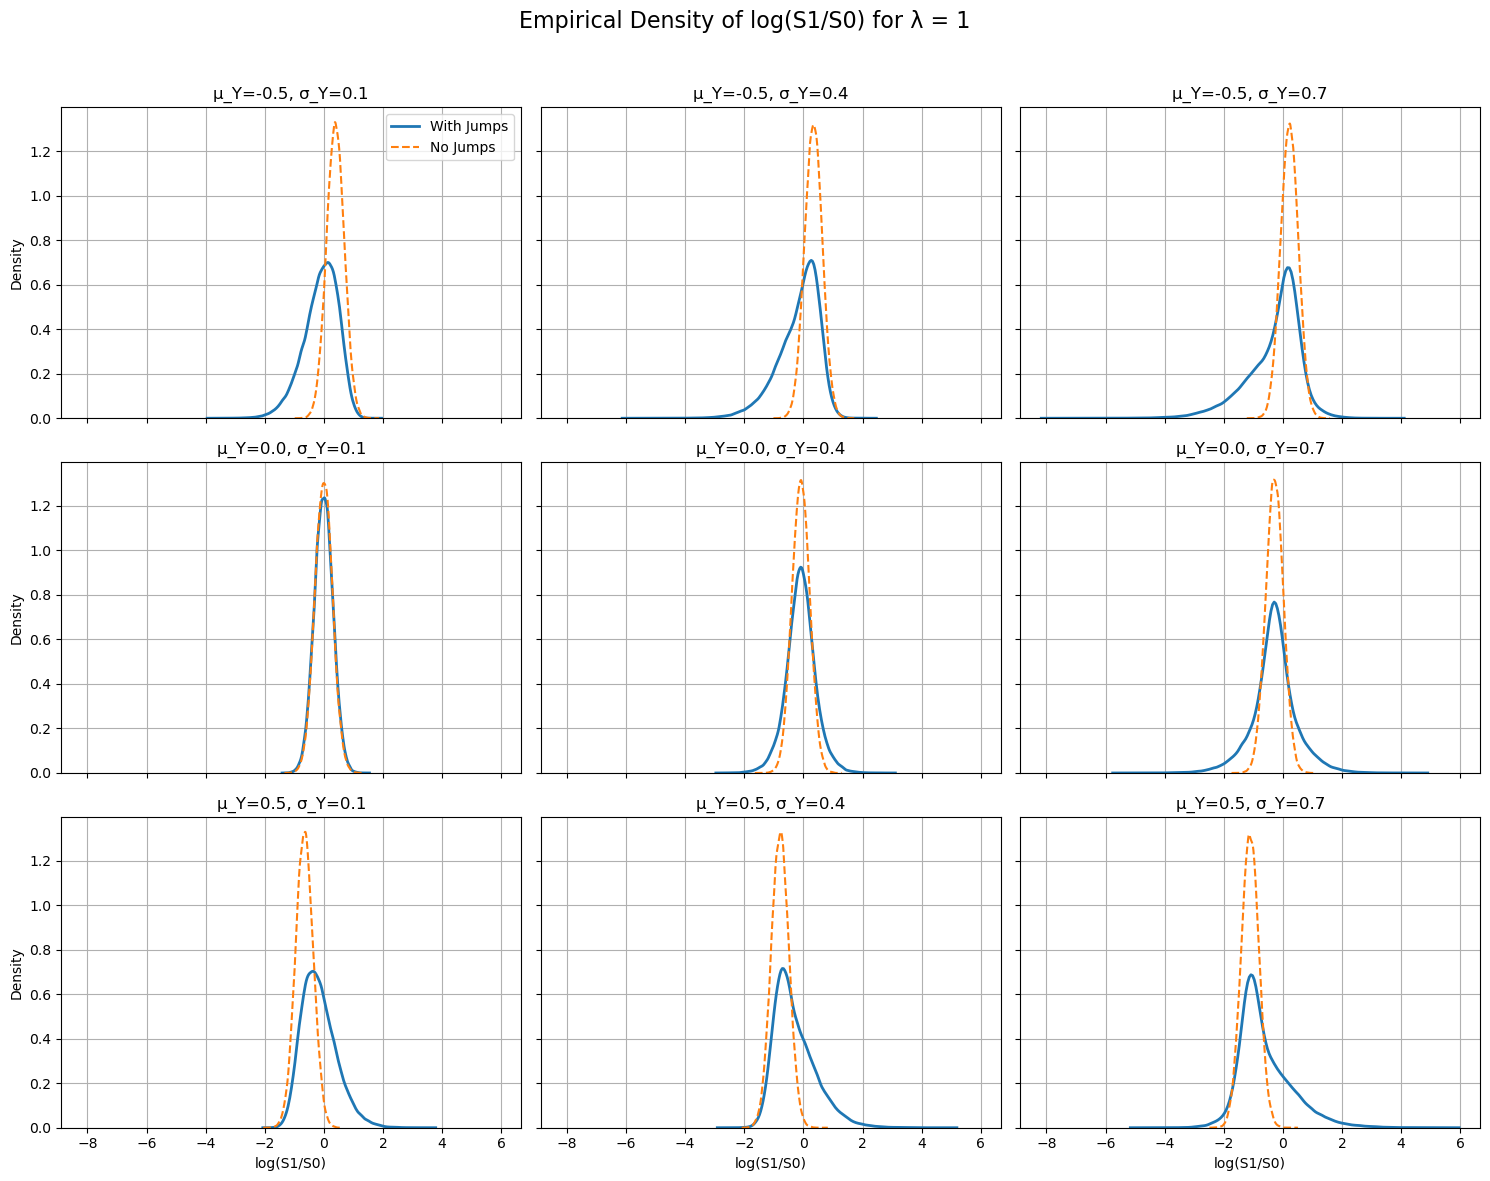

C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

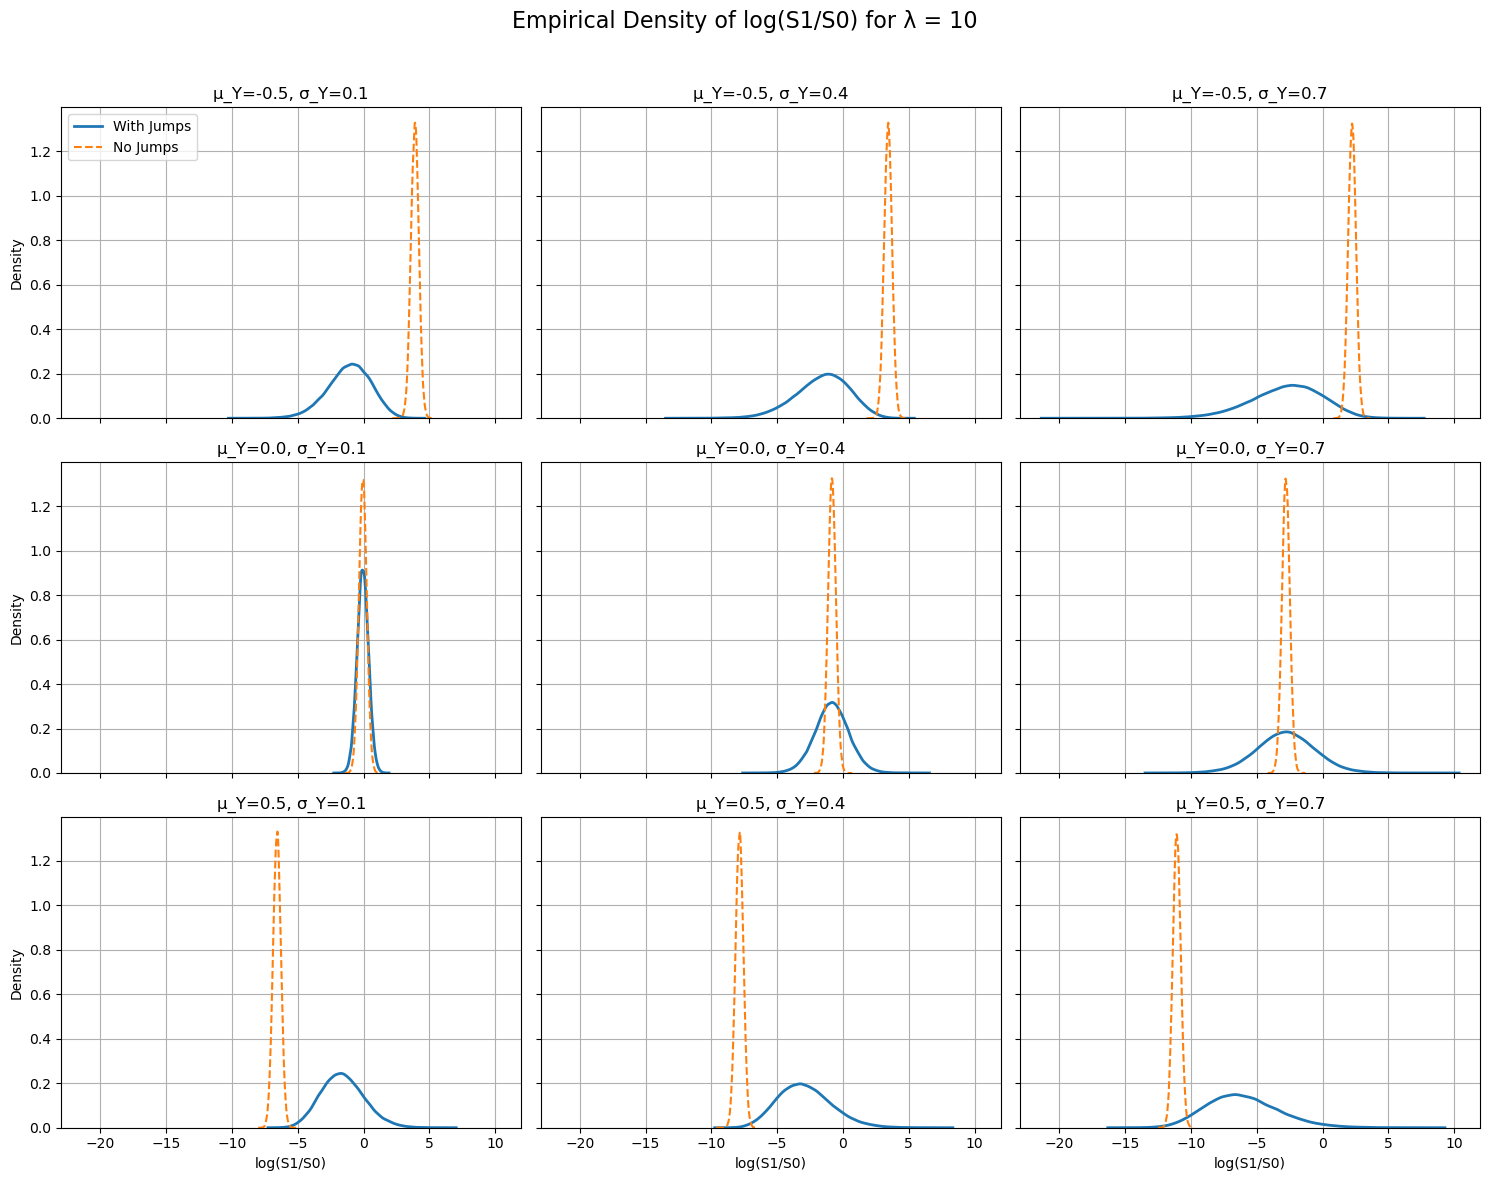

C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

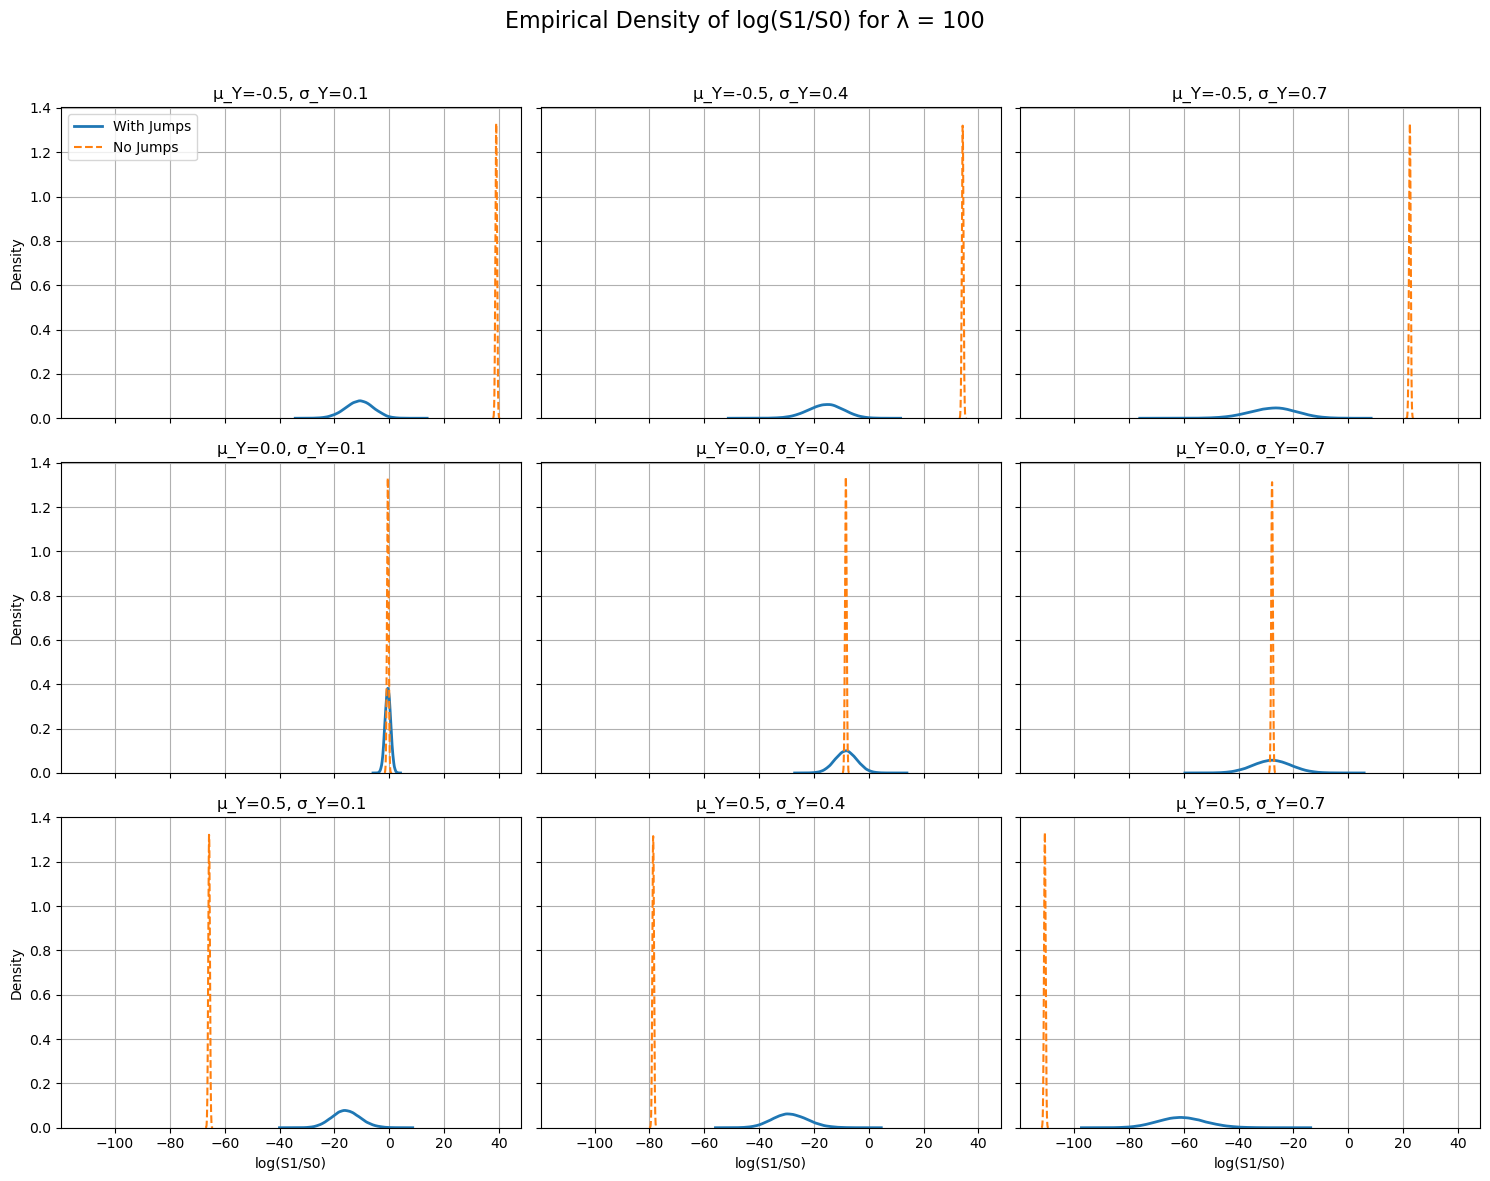

+----+----------+---------+--------+----------+--------+------------+-------------------+
|    |        λ |     μ_Y |    σ_Y |     Mean |    Std |   Skewness |   Excess Kurtosis |
+====+==========+=========+========+==========+========+============+===================+
|  0 |   1.0000 | -0.5000 | 0.1000 |  -0.1118 | 0.5897 |    -0.6540 |            0.5674 |
+----+----------+---------+--------+----------+--------+------------+-------------------+
|  1 |   1.0000 | -0.5000 | 0.4000 |  -0.1619 | 0.7065 |    -1.0265 |            1.5317 |
+----+----------+---------+--------+----------+--------+------------+-------------------+
|  2 |   1.0000 | -0.5000 | 0.7000 |  -0.2811 | 0.9138 |    -1.1276 |            2.1826 |
+----+----------+---------+--------+----------+--------+------------+-------------------+
|  3 |   1.0000 |  0.0000 | 0.1000 |  -0.0108 | 0.3165 |     0.0047 |            0.0285 |
+----+----------+---------+--------+----------+--------+------------+-------------------+
|  4 |   1

In [2]:
S0 = 100
T = 1
mu = 0.04
sigma = 0.3
N_sim = 100000

lambdas = [1, 10, 100]
mu_Ys = [-0.5, 0.0, 0.5]
sigma_Ys = [0.1, 0.4, 0.7]

results = []

# --- For each lambda, create a subplot grid ---
for lam in lambdas:
    fig, axes = plt.subplots(len(mu_Ys), len(sigma_Ys), figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"Empirical Density of log(S1/S0) for λ = {lam}", fontsize=16)

    for i, mu_Y in enumerate(mu_Ys):
        for j, sigma_Y in enumerate(sigma_Ys):
            kappa = np.exp(mu_Y + 0.5 * sigma_Y**2) - 1

            B = np.random.normal(0, np.sqrt(T), N_sim)
            X_tilde = (mu - lam * kappa - 0.5 * sigma**2) * T + sigma * B

            N_jump = np.random.poisson(lam * T, N_sim)
            jump_sizes = np.array([
                np.sum(np.random.normal(mu_Y, sigma_Y, n)) if n > 0 else 0 for n in N_jump
            ])

            X = X_tilde + jump_sizes
            log_returns = X

            # Stats
            results.append({
                'λ': lam,
                'μ_Y': mu_Y,
                'σ_Y': sigma_Y,
                'Mean': np.mean(log_returns),
                'Std': np.std(log_returns),
                'Skewness': skew(log_returns),
                'Excess Kurtosis': kurtosis(log_returns)
            })

            ax = axes[i, j]
            sns.kdeplot(log_returns, ax=ax, label="With Jumps", linewidth=2)
            sns.kdeplot(X_tilde, ax=ax, label="No Jumps", linestyle="--")

            ax.set_title(f"μ_Y={mu_Y}, σ_Y={sigma_Y}")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.grid(True)

            if i == len(mu_Ys) - 1:
                ax.set_xlabel("log(S1/S0)")
            if j == 0:
                ax.set_ylabel("Density")
            if i == 0 and j == 0:
                ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Show result summary table ---
df = pd.DataFrame(results)
print(tabulate(df, headers="keys", tablefmt="grid", floatfmt=".4f"))


In [3]:

# --- Black-Scholes Call Formula ---
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# --- Implied Volatility Solver ---
def implied_vol_call(S, K, T, r, price, tol=1e-6):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - price, 1e-6, 3.0, xtol=tol)
    except ValueError:
        return np.nan

# --- Parameters ---
S0 = 100
r = 0.05
T = 1
K = 100
mu = 0.1         # drift
sigma = 0.2      # diffusion volatility
lambda_ = 2      # average jumps per year
mu_Y = -0.1      # average jump size
sigma_Y = 0.3    # jump size volatility
N_sim = 100000

# --- Simulate log(S_T) under Merton Model ---
kappa = np.exp(mu_Y + 0.5 * sigma_Y**2) - 1
drift = (mu - lambda_ * kappa - 0.5 * sigma**2) * T
B = np.random.normal(0, np.sqrt(T), N_sim)
N_jump = np.random.poisson(lambda_ * T, N_sim)
jump_sum = np.array([np.sum(np.random.normal(mu_Y, sigma_Y, n)) if n > 0 else 0 for n in N_jump])
log_ST = np.log(S0) + drift + sigma * B + jump_sum
ST = np.exp(log_ST)

# --- Monte Carlo Call Price ---
payoffs = np.maximum(ST - K, 0)
call_price = np.exp(-r * T) * np.mean(payoffs)
std = np.std(np.exp(-r * T) * payoffs, ddof=1)
conf_int = (
    call_price - 1.96 * std / np.sqrt(N_sim),
    call_price + 1.96 * std / np.sqrt(N_sim)
)

# --- Implied Volatility ---
implied_vol = implied_vol_call(S0, K, T, r, call_price)

# --- Report ---
print(f"Simulated Merton Jump-Diffusion Call Price: {call_price:.4f}")
print(f"Standard Deviation: {std:.4f}")
print(f"95% Confidence Interval: {conf_int}")
print(f"Implied Volatility from BS Model: {implied_vol:.4f}")


Simulated Merton Jump-Diffusion Call Price: 23.4329
Standard Deviation: 40.2440
95% Confidence Interval: (23.183452943685765, 23.68232335248114)
Implied Volatility from BS Model: 0.5438


# 2.

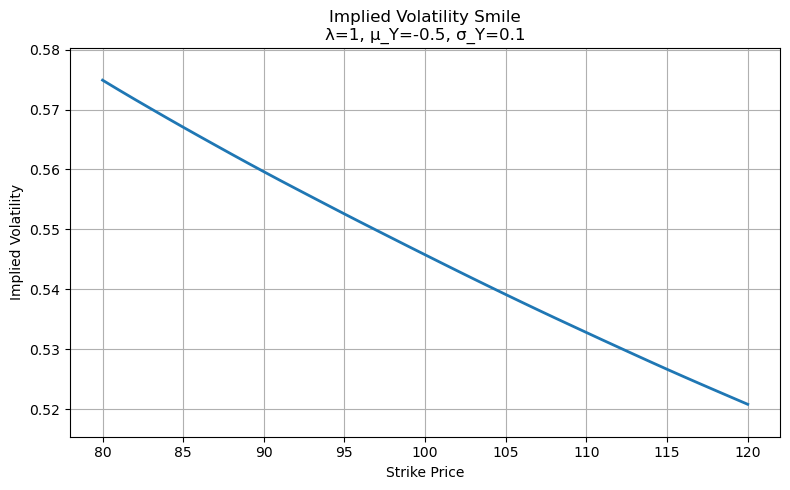

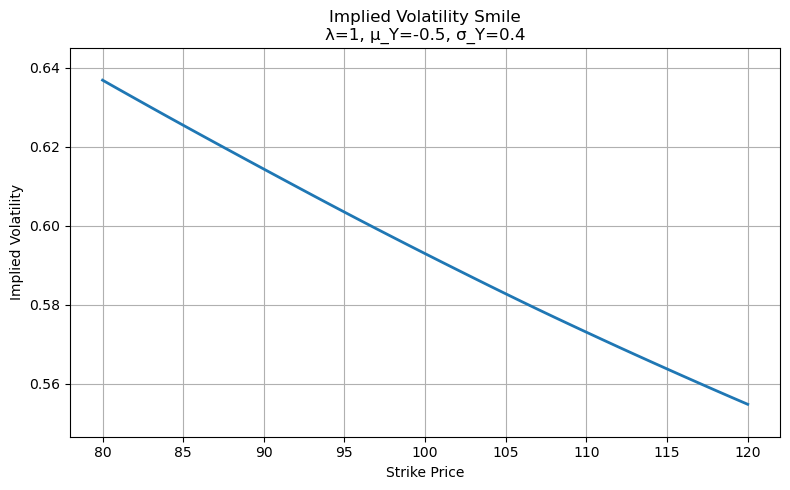

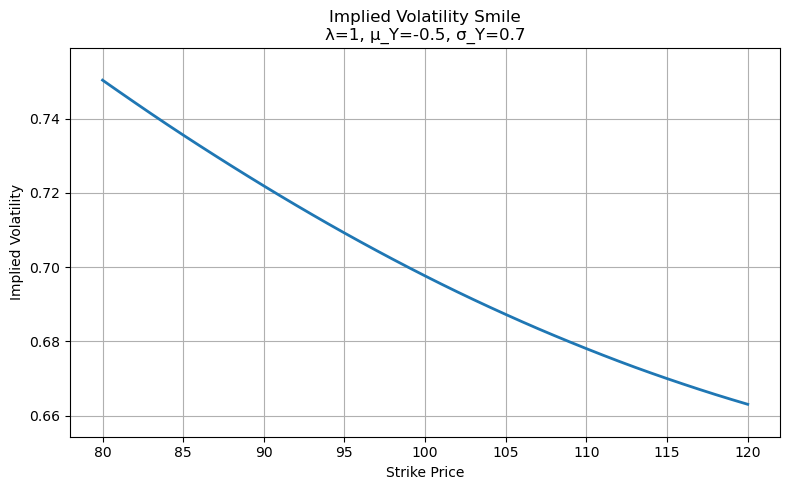

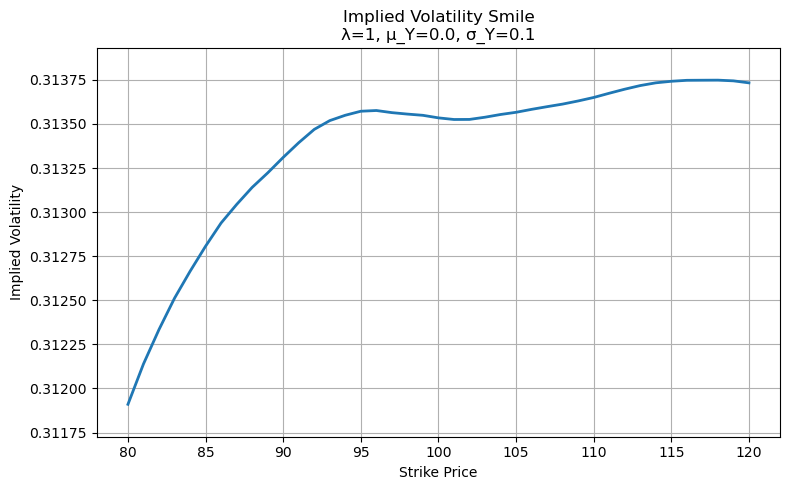

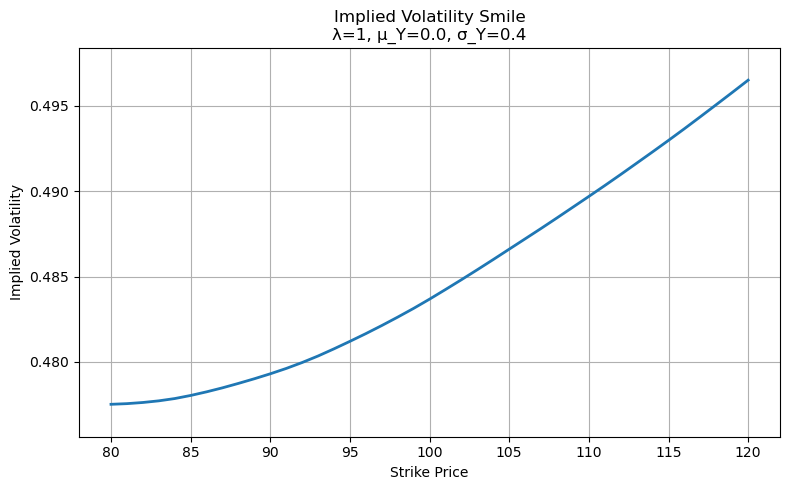

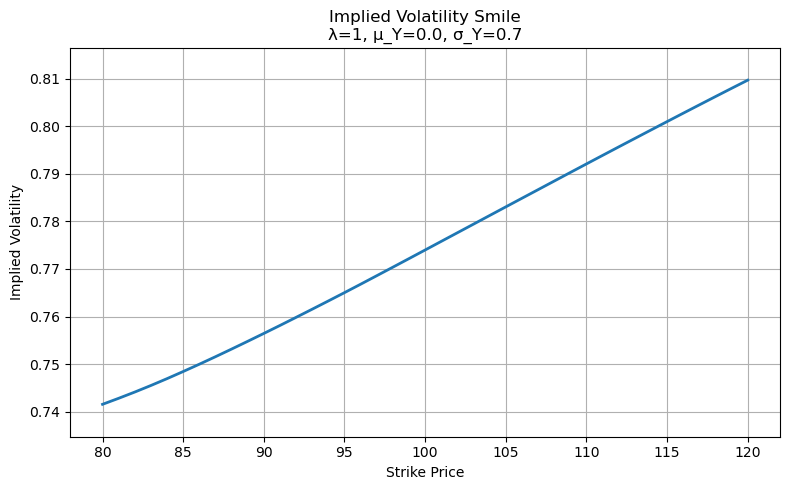

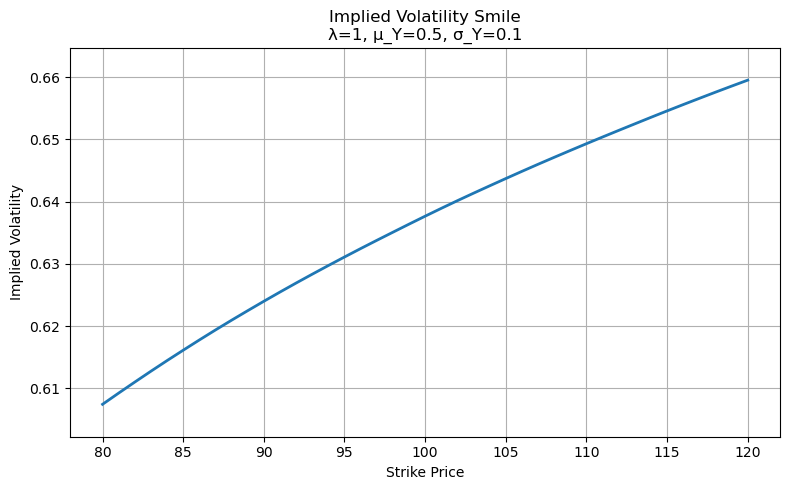

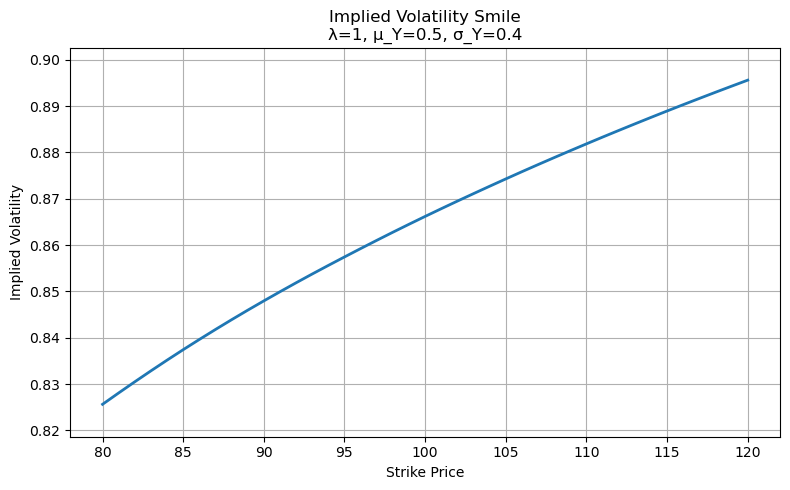

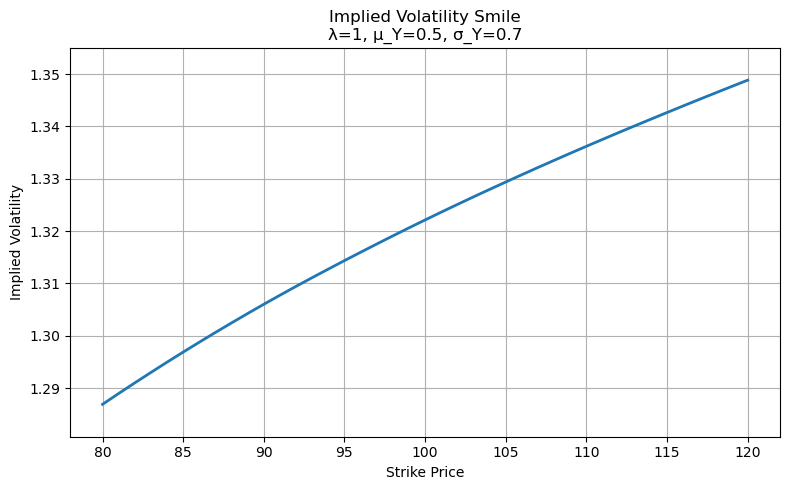

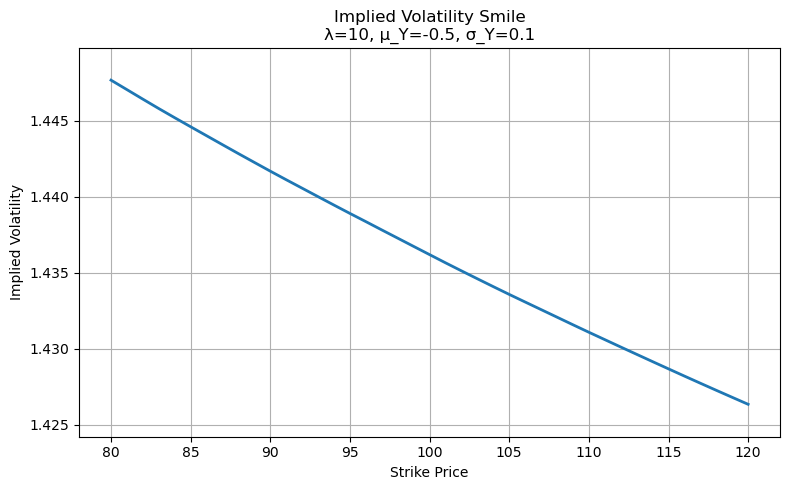

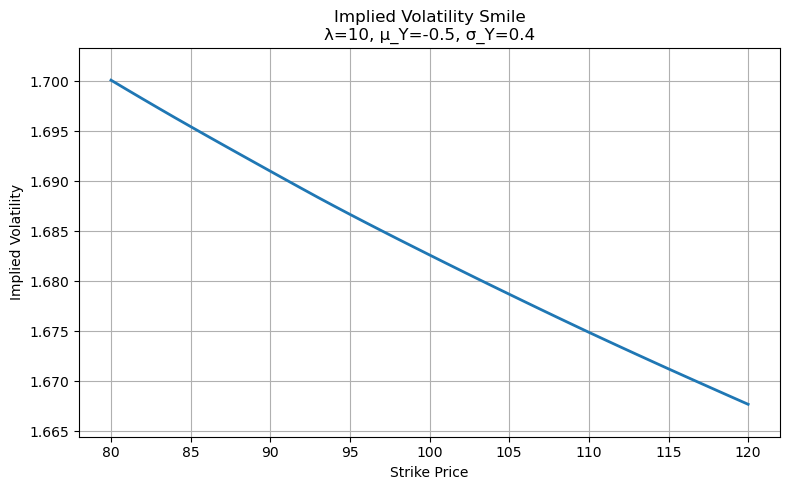

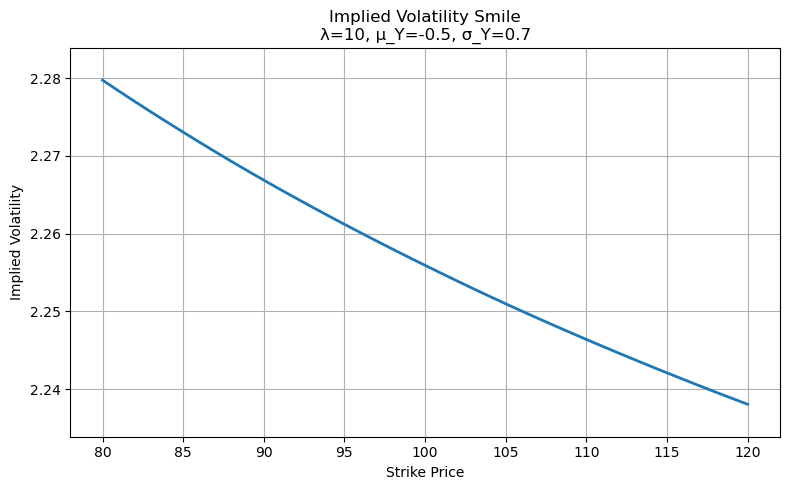

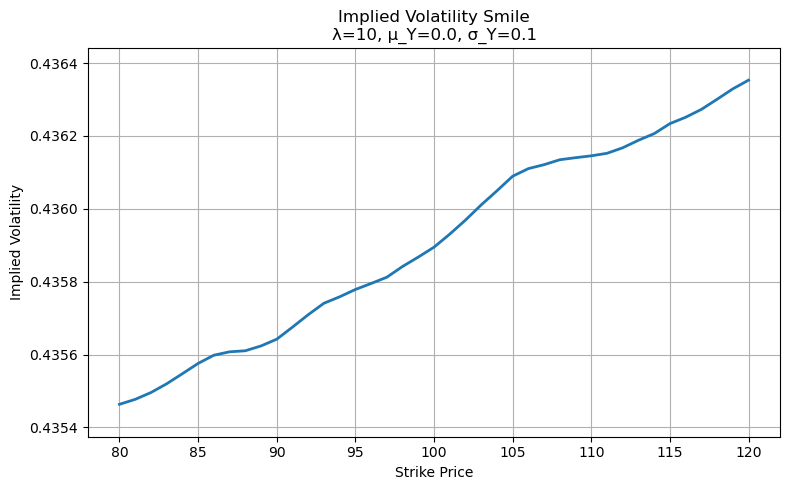

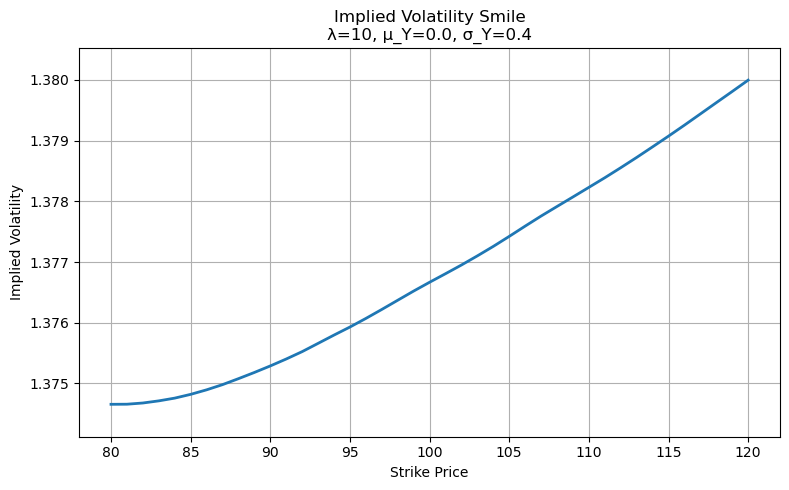

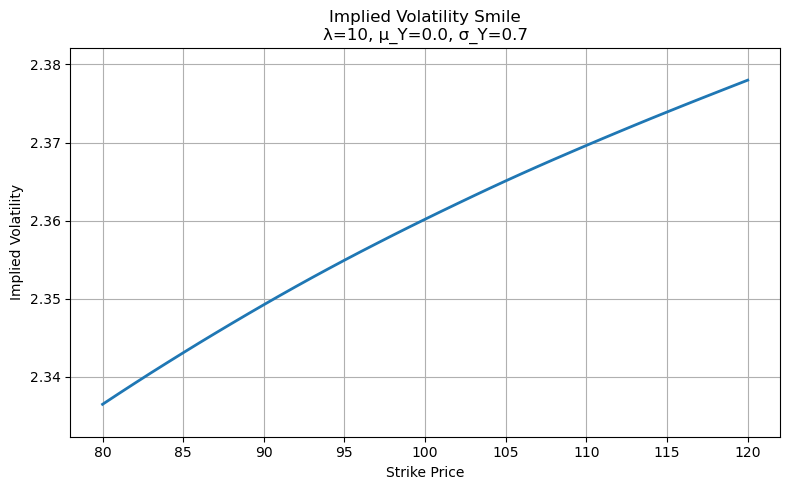

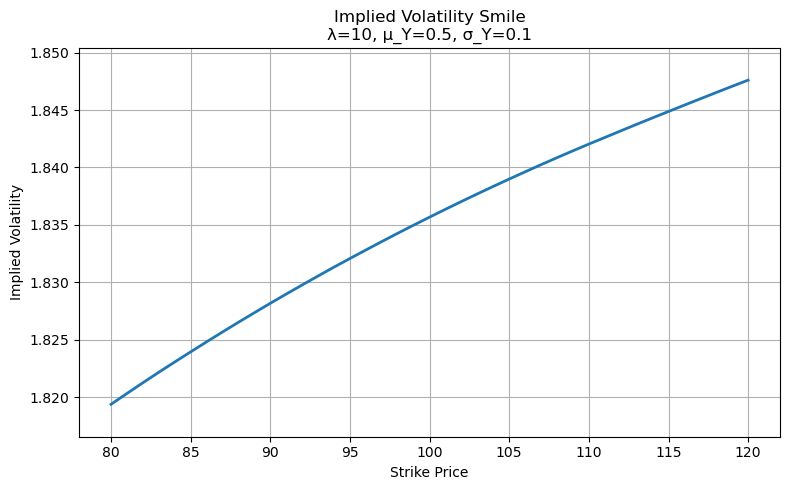

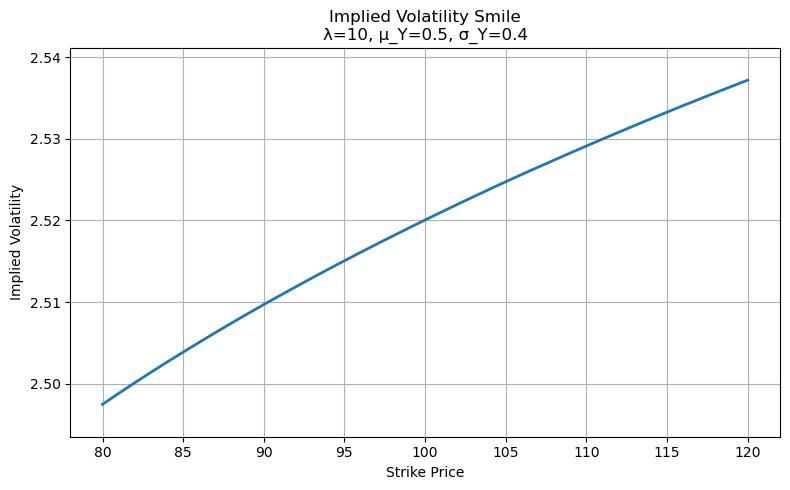

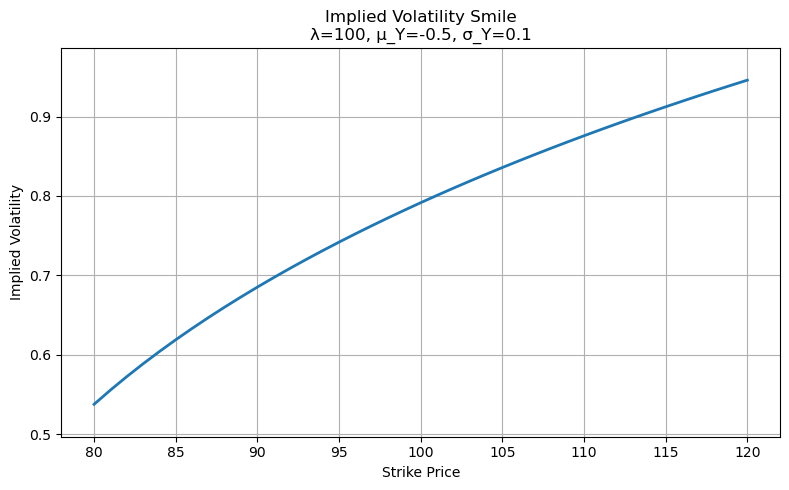

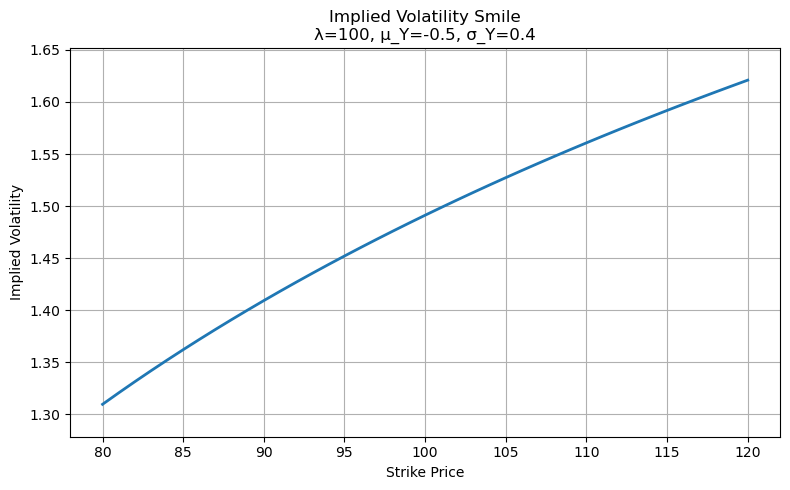

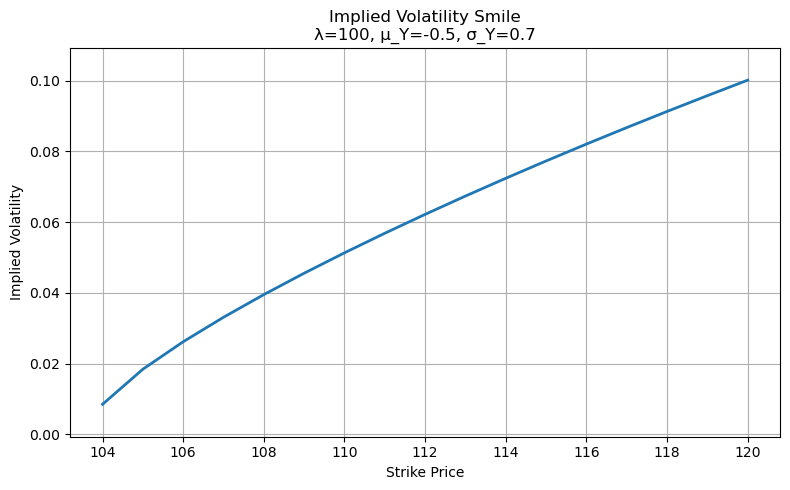

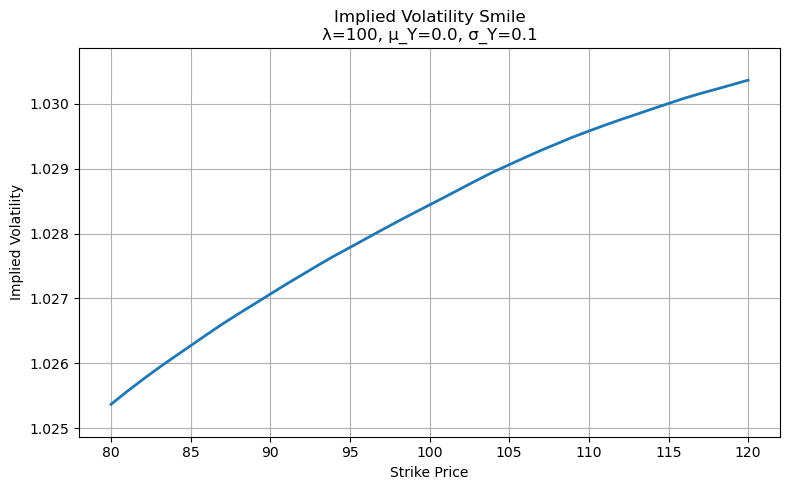

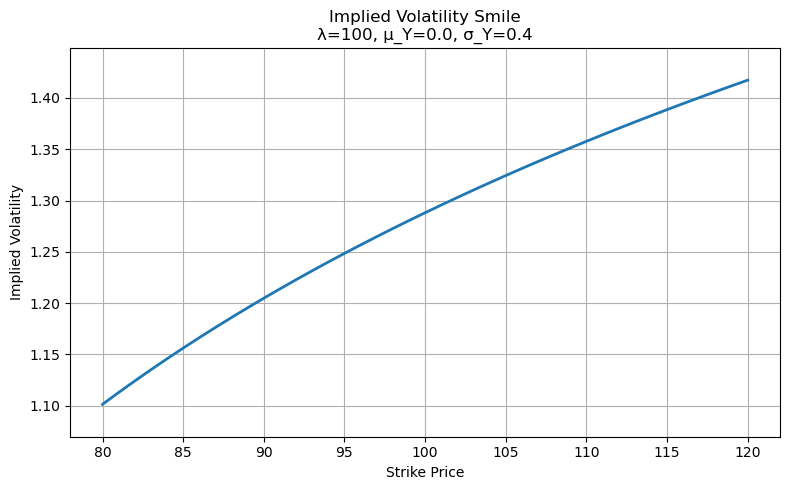

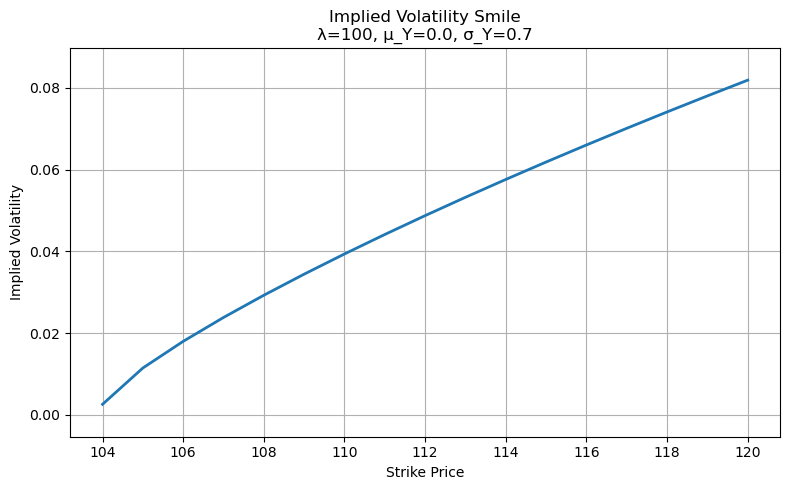

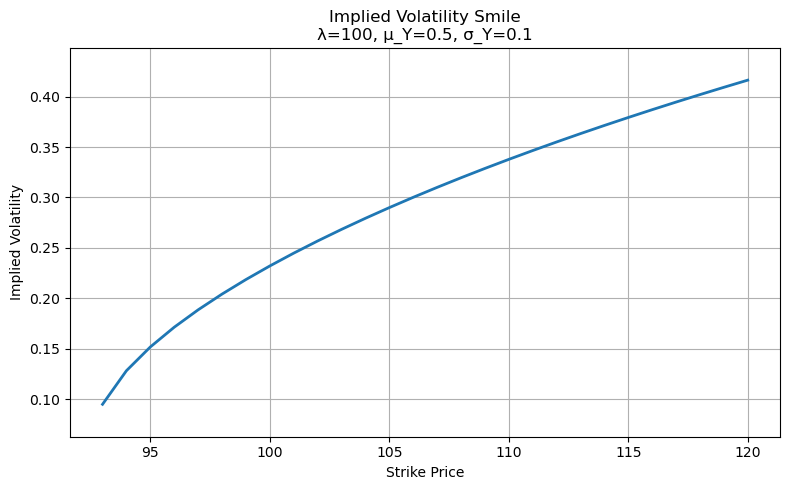

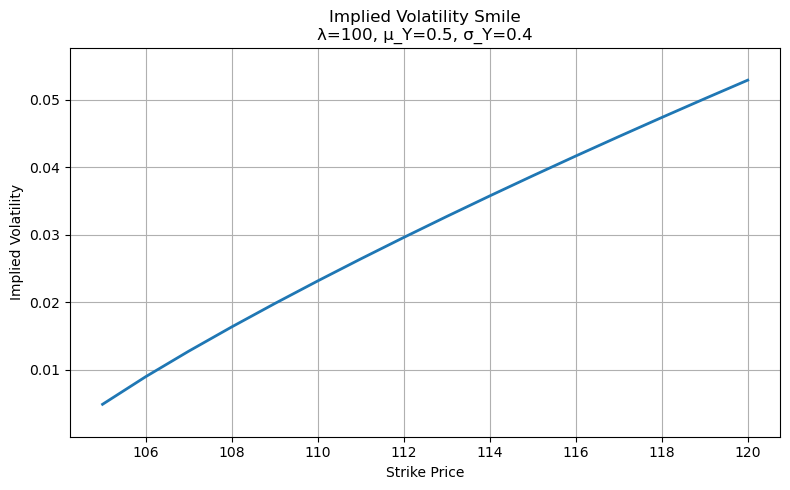

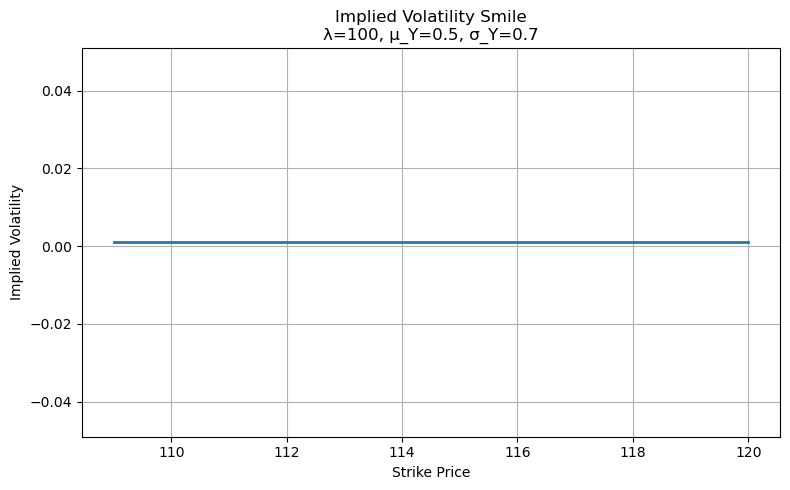

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Parameters
S0 = 100
r = 0.04
T = 1
strikes = np.arange(80, 121)
N_sim = 100000
mu = 0.04
sigma = 0.3

lambdas = [1, 10, 100]
mu_Ys = [-0.5, 0.0, 0.5]
sigma_Ys = [0.1, 0.4, 0.7]

# Black-Scholes Call Price
def bs_call_price(S, K, T, r, vol):
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Implied Volatility Solver
def implied_vol(C_market, S, K, T, r):
    def objective(vol):
        return bs_call_price(S, K, T, r, vol) - C_market
    try:
        return brentq(objective, 0.001, 5.0)
    except ValueError:
        return np.nan

# Loop through parameter combos
for lam in lambdas:
    for mu_Y in mu_Ys:
        for sigma_Y in sigma_Ys:
            kappa = np.exp(mu_Y + 0.5 * sigma_Y**2) - 1

            # Simulate X_tilde and jumps
            B = np.random.normal(0, np.sqrt(T), N_sim)
            X_tilde = (mu - lam * kappa - 0.5 * sigma**2) * T + sigma * B

            N_jump = np.random.poisson(lam * T, N_sim)
            jump_sizes = np.array([
                np.sum(np.random.normal(mu_Y, sigma_Y, n)) if n > 0 else 0 for n in N_jump
            ])

            X = X_tilde + jump_sizes
            S1 = S0 * np.exp(X)

            call_prices = [np.mean(np.maximum(S1 - K, 0)) * np.exp(-r * T) for K in strikes]
            ivs = [implied_vol(c, S0, K, T, r) for c, K in zip(call_prices, strikes)]

            ivs = np.array(ivs)
            valid_ivs = ivs[~np.isnan(ivs)]

            # Only plot if there's enough valid data
            if len(valid_ivs) > 3:
                # Dynamically scale y-axis
                y_min = valid_ivs.min()
                y_max = valid_ivs.max()
                y_margin = 0.1 * (y_max - y_min) if y_max > y_min else 0.05

                plt.figure(figsize=(8, 5))
                plt.plot(strikes, ivs, lw=2)
                plt.title(f"Implied Volatility Smile\nλ={lam}, μ_Y={mu_Y}, σ_Y={sigma_Y}")
                plt.xlabel("Strike Price")
                plt.ylabel("Implied Volatility")
                plt.ylim(y_min - y_margin, y_max + y_margin)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
